In [209]:
#import libraries

import numpy as np
import pandas as pd
from numpy import log, polyfit, sqrt, std, subtract
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

data = pd.read_csv("D:\AlgoTradeSoft\candles_EUR_5.csv")
data.head()

,Timestamp,BTCUSD,ETHUSD,BTCEUR,BTCGBP,BTCJPY,ETHEUR,ETHJPY,EOSEUR,ETHBTC,Unnamed: 10
0,2018-4-24 16:5:0,9345.0,700.52,7642.064286,6686.900000,1.021294e+06,573.482035,76596.945697,11.133000,0.05972,NaN
1,2018-4-24 16:10:0,9344.8,700.47,7644.400000,6688.600000,1.020100e+06,573.482035,76596.945697,11.144000,0.05972,NaN
2,2018-4-24 16:15:0,9354.4,700.26,7643.843711,6688.378150,1.020400e+06,573.482035,76596.945697,11.144882,0.05972,NaN
3,2018-4-24 16:20:0,9370.0,700.01,7659.000000,6698.709232,1.019607e+06,572.188874,76182.089700,11.352000,0.05972,NaN
4,2018-4-24 16:25:0,9345.0,697.07,7637.000000,6682.000000,1.019400e+06,569.793889,75889.336995,11.337352,0.05972,NaN


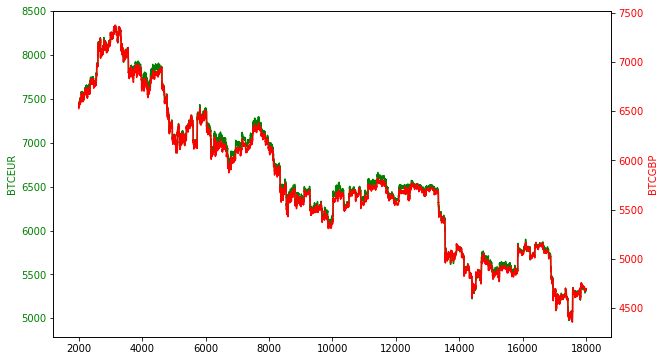

In [217]:
#set symbols and range

symbols = ['BTCEUR', 'BTCGBP']
start = 2000
end = 18000

y = data.loc[start:end, symbols[1]]
x = data.loc[start:end, symbols[0]]

# plot timeseries

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.plot(x, color = 'g')
ax1.set_ylabel(symbols[0], color = 'g')
for tl in ax1.get_yticklabels():
    tl.set_color('g')
    
ax2 = ax1.twinx()
ax2.plot(y, 'r-')
ax2.set_ylabel(symbols[1], color = 'r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

# calculate beta from regression

df1 = pd.DataFrame({'y': y, 'x': x})
est = sm.OLS(df1.y, df1.x).fit()
df1['hr'] = est.params[0]
df1['spread'] = df1.y - (df1.x * df1.hr)
beta = est.params[0]



regular spread:  Critical: -3.41 p-value: 0.011 Beta: 0.87810 Hurst  = 0.14 Halflife:  14.0
opted spread:    Critical: -3.41 p-value: 0.011 Beta: 0.87810 Hurst  = 0.14 Halflife:  14.0


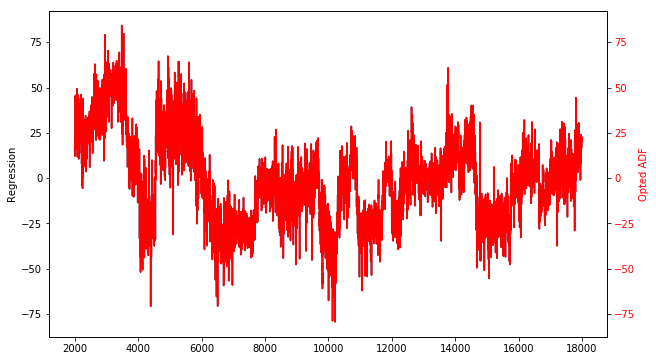

In [218]:
# optimise beta w ADF

rbeta = beta
step = rbeta / 10
lowr = step
higr = rbeta + rbeta

bvalues = []

while lowr < higr:
    spreadt = y - x * lowr
    result = ts.adfuller(spreadt)
    pval = result[1]
    crit = result[0]
    bvalues.append((lowr, pval, crit))
    lowr += step
    
ps = pd.DataFrame(bvalues, columns = ['beta', 'pval', 'critical'])    
bvalues.sort(key=lambda x: x[1]) 

obeta = bvalues[0][0]

df1['ohr'] = obeta
df1['ospread'] = df1.y - df1.x * obeta

fig2 = plt.figure(figsize=(10,6))
ax1 = fig2.add_subplot(111)
ax1.plot(df1.spread)
ax1.set_ylabel('Regression')

ax2 = ax1.twinx()
ax2.plot(df1.ospread, color = 'r')
ax2.set_ylabel('Opted ADF', color = 'r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

result1 = ts.adfuller(df1.spread)
result2 = ts.adfuller(df1.ospread)


#calculate Hurst Exponent

def hurst(ts):
    lags = range(2,100)
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = polyfit(log(lags), log(tau), 1)
    return poly[0] * 2.0

# claculate Halflife

spread_lag = df1.spread.shift(1)
spread_lag.iloc[0] = spread_lag.iloc[1]
spread_ret = df1.spread - spread_lag
spread_ret.iloc[0] = spread_ret.iloc[1]
spread_lag2 = sm.add_constant(spread_lag)

model = sm.OLS(spread_ret, spread_lag2)
res = model.fit()

halflife = round(-np.log(2) / res.params[1], 0)


spread_lag = df1.ospread.shift(1)
spread_lag.iloc[0] = spread_lag.iloc[1]
spread_ret = df1.ospread - spread_lag
spread_ret.iloc[0] = spread_ret.iloc[1]
spread_lag2 = sm.add_constant(spread_lag)

model = sm.OLS(spread_ret, spread_lag2)
res = model.fit()

halflife2 = round(-np.log(2) / res.params[1], 0)


print('regular spread: ','Critical: ''%.2f' % result1[0],'p-value: ''%.3f' % result1[1], 'Beta: ''%.5f' % beta, 'Hurst  =', round(hurst(df1.spread),2), 'Halflife: ', halflife)
print('opted spread:   ','Critical: ''%.2f' % result2[0],'p-value: ''%.3f' % result2[1], 'Beta: ''%.5f' % obeta, 'Hurst  =', round(hurst(df1.ospread),2), 'Halflife: ', halflife2)



In [215]:
meanSpread = df1.spread.rolling(int(halflife)).mean()
stdSpread = df1.spread.rolling(int(halflife)).std()

df1['zScore'] = (df1.spread - meanSpread)/stdSpread

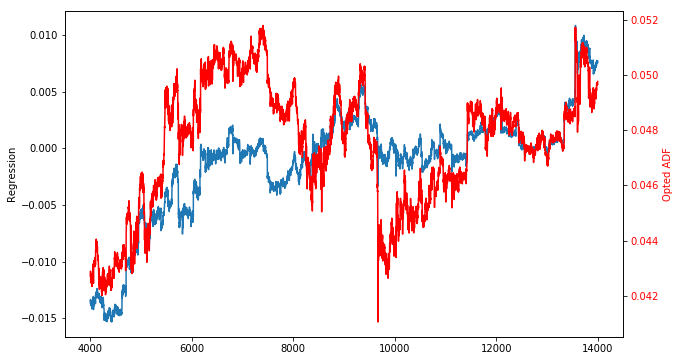

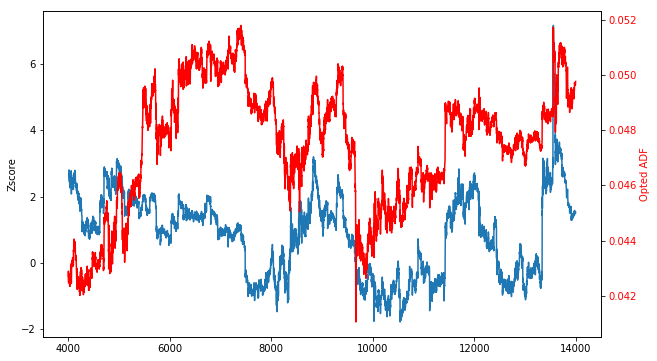

In [216]:
srange = 2000
erange = 12000

fig2 = plt.figure(figsize=(10,6))
ax1 = fig2.add_subplot(111)
ax1.plot(df1.spread[srange:erange])
ax1.set_ylabel('Regression')

ax2 = ax1.twinx()
ax2.plot(df1.ospread[srange:erange], color = 'r')
ax2.set_ylabel('Opted ADF', color = 'r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

fig2 = plt.figure(figsize=(10,6))
ax1 = fig2.add_subplot(111)
ax1.plot(df1.zScore[srange:erange])
ax1.set_ylabel('Zscore')

ax2 = ax1.twinx()
ax2.plot(df1.ospread[srange:erange], color = 'r')
ax2.set_ylabel('Opted ADF', color = 'r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

In [219]:
os?

In [222]:
os.getcwd()

'D:\\Phyton'